In [21]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import keras

from tensorflow.keras.layers import RandomTranslation, RandomZoom, RandomRotation

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path

project_root = Path().resolve().parent
if not project_root in [Path(p).resolve() for p in sys.path]:
    sys.path.append(str(project_root))

from src import PATHS

## Travail sur un échantilon

In [9]:
sample = pd.read_parquet(os.path.join(project_root,'data', 'metadata', 'samples', 'df_documents_sample_40k_1.parquet'), engine='fastparquet')

converted_prefix = os.path.join(project_root, 'data', 'converted')
sample['filepath'] = sample['rvl_image_path'].apply(lambda p: os.path.join(converted_prefix, p.replace("raw/", "").replace(".tif", ".jpg")))
sample = sample.drop(columns=['rvl_image_path', 'document_id', 'filename', 'iit_image_path', 'iit_individual_xml_path', 'iit_collective_xml_path'])

## Création des sets

In [10]:
# 1. Encodage des labels : pas besoin ? 
label_encoder = LabelEncoder()
sample['label_encoded'] = label_encoder.fit_transform(sample['label'])

# 2. On part de sample pour créer les différents sets
df_train = sample[sample['data_set'] == 'train']
df_val = sample[sample['data_set'] == 'val']
df_test = sample[sample['data_set'] == 'test']

# 3. Fonction pour charger et prétraiter une image
def process_image(file_path, label, augment=False):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)
    if augment:
        image = data_augmentation(image)
    return image, label

# 4. Création du dataset
def get_dataset(df_subset, shuffle=False, augment=False):
    file_paths = df_subset['filepath'].values
    labels = df_subset['label_encoded'].values
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: process_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = get_dataset(df_train, shuffle=True)
val_ds = get_dataset(df_val)
test_ds = get_dataset(df_test)

In [6]:
# Charger la base ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches sauf 10
base_model.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Construction du modèle
inputs = Input(shape=(224, 224, 3))

#On teste quelques augmentations: NON, ça donne des résultats mauvais
#x = tf.keras.layers.RandomRotation(0.02)(inputs)
#x = tf.keras.layers.RandomZoom(0.1)(x)
#x = tf.keras.layers.RandomContrast(0.1)(x)
#x = tf.keras.layers.RandomTranslation(0.05, 0.05)(x)

#on envoie tout ça dans le modèle
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(16, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(patience=5, min_delta=0.001, verbose=1, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Entraînement
history_1 = model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=10,
                      callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.4405 - loss: 1.8290  
Epoch 1: val_loss improved from inf to 1.12669, saving model to best_resnet_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 563s 558ms/step - accuracy: 0.4406 - loss: 1.8287 - val_accuracy: 0.6571 - val_loss: 1.1267 - learning_rate: 1.0000e-04
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.6683 - loss: 1.0802  
Epoch 2: val_loss improved from 1.12669 to 0.94473, saving model to best_resnet_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 556s 556ms/step - accuracy: 0.6683 - loss: 1.0801 - val_accuracy: 0.7171 - val_loss: 0.9447 - learning_rate: 1.0000e-04
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.7423 - loss: 0.8506  
Epoch 3: val_loss did not improve from 0.94473
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 555s 555ms/step - accuracy: 0.7424 - loss: 0.8505 - val_accuracy: 0.7323 - val_loss: 0.9474 - learning_rate: 1.0000e-04
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s

In [7]:
# On relance après avoir dégelé des couches (il y en a 177 en tout dans ResNet donc là on en dégèle 27 supplémentaires, soit 37

base_model.trainable = True
for layer in base_model.layers[:140]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_2 = model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=10,
                      callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.6558 - loss: 1.2464   
Epoch 1: val_loss did not improve from 0.87914
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 718s 711ms/step - accuracy: 0.6559 - loss: 1.2461 - val_accuracy: 0.7438 - val_loss: 1.0256 - learning_rate: 1.0000e-05
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.8612 - loss: 0.4300   
Epoch 2: val_loss did not improve from 0.87914
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 705s 704ms/step - accuracy: 0.8613 - loss: 0.4299 - val_accuracy: 0.7638 - val_loss: 1.0493 - learning_rate: 1.0000e-05
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9189 - loss: 0.2568   
Epoch 3: val_loss did not improve from 0.87914
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 705s 705ms/step - accuracy: 0.9189 - loss: 0.2568 - val_accuracy: 0.7638 - val_loss: 1.1352 - learning_rate: 1.0000e-05
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.9557 - loss: 0.1394   
Epoch 4: val_loss did not improve 

In [8]:
# encore une étape de dégelage, on rajoute 20 couches à entrainer 

for layer in base_model.layers[:120]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_3 = model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=10,
                      callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.9874 - loss: 0.0438   
Epoch 1: val_loss did not improve from 0.87914
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 726s 719ms/step - accuracy: 0.9874 - loss: 0.0438 - val_accuracy: 0.7681 - val_loss: 1.3715 - learning_rate: 1.0000e-05
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.9883 - loss: 0.0371   
Epoch 2: val_loss did not improve from 0.87914
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 712s 712ms/step - accuracy: 0.9883 - loss: 0.0371 - val_accuracy: 0.7663 - val_loss: 1.4009 - learning_rate: 1.0000e-05
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.9913 - loss: 0.0289   
Epoch 3: val_loss did not improve from 0.87914
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 714s 713ms/step - accuracy: 0.9913 - loss: 0.0289 - val_accuracy: 0.7736 - val_loss: 1.4296 - learning_rate: 1.0000e-05
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.9922 - loss: 0.0267   
Epoch 4: val_loss did not improve 

In [9]:
def combine_histories(*histories):
    combined = {}
    for key in histories[0].history.keys():
        combined[key] = sum((h.history[key] for h in histories), [])
    return combined

combined_history = combine_histories(history_1, history_2, history_3)

In [10]:
# Save the best model
model.save(os.path.join(project_root,'models','ResNet50_best_30_epocs_sample_40_000_unfreeze_step_by_step.keras'))

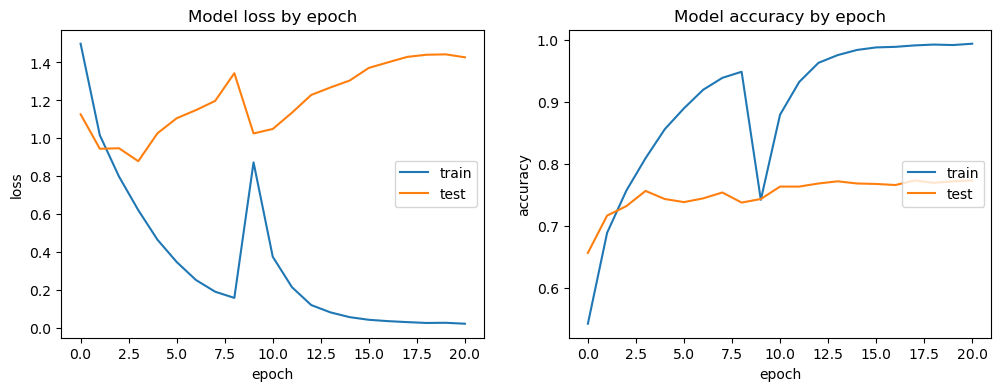

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(combined_history['loss'])
plt.plot(combined_history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(combined_history['accuracy'])
plt.plot(combined_history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [2]:
model = keras.saving.load_model(os.path.join(project_root,'models','ResNet50_best_30_epocs_sample_40_000_unfreeze_step_by_step.keras'))

In [11]:
# Étape 1 : Prédire sur le test set
y_pred_probs = model.predict(test_ds)  # Probabilités
y_pred = np.argmax(y_pred_probs, axis=1)  # Classes prédites

# Étape 2 : Récupérer les vrais labels depuis le test set, dans le même ordre
y_true_check = []
for batch in test_ds:
    images, labels = batch
    y_true_check.extend(labels.numpy())

y_true = np.array(y_true_check)

# Étape 3 : Rapport de classification
print("\n Rapport de classification :")
print(classification_report(y_true, y_pred))



125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 465ms/step

 Rapport de classification :
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       246
           1       0.60      0.62      0.61       251
           2       0.89      0.97      0.93       252
           3       0.84      0.89      0.86       253
           4       0.81      0.84      0.82       251
           5       0.58      0.60      0.59       250
           6       0.88      0.86      0.87       257
           7       0.85      0.86      0.85       247
           8       0.85      0.89      0.87       253
           9       0.83      0.79      0.81       246
          10       0.72      0.70      0.71       250
          11       0.79      0.73      0.76       248
          12       0.63      0.69      0.66       249
          13       0.73      0.63      0.68       243
          14       0.89      0.89      0.89       254
          15       0.78      0.66      0.71       249

    ac

Matrice de confusion :


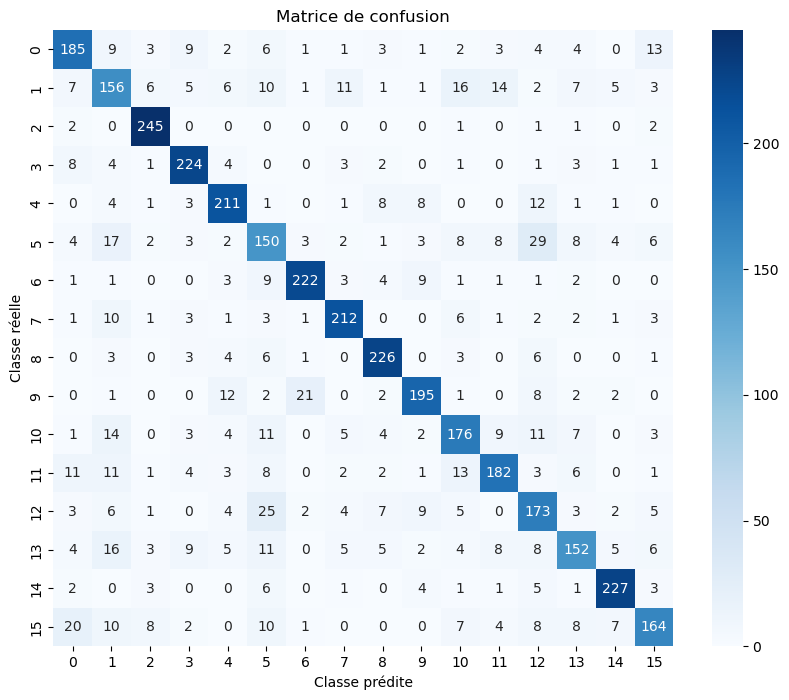

In [12]:
# Étape 4 : Matrice de confusion
print("Matrice de confusion :")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()